In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from datetime import datetime,timedelta
from netCDF4 import Dataset,num2date,date2num
from scipy import stats, signal
from scipy.ndimage import uniform_filter1d
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.standard import Eof
from sklearn.cluster import KMeans
from numpy.polynomial import Polynomial

Based on the method of Lee et al. (2023, J. Climate) but using a running mean rather than Fourier filter, and option for back extension to 1940 with polynomial detrending.

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [3]:
def running_mean_2d(data, window_size):

    # Create a 1D convolution kernel with equal weights for the running mean
    kernel = np.ones(window_size) / window_size

    # Apply the running mean along the time axis
    result = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=0, arr=data)    
    # pad the edges with the original data
    result[:int(window_size/2)]=data[:int(window_size/2)]
    result[-int(window_size/2):]=data[-int(window_size/2):]
    return result

In [4]:
def make_boundary_path(minlon,maxlon,minlat,maxlat,n=50):
    '''
    return a matplotlib Path whose points are a lon-lat box given by
    the input parameters
    '''
    boundary_path = []
    #North (E->W)
    edge = [np.linspace(minlon,maxlon,n), np.full(n,maxlat)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #West (N->S)
    edge = [np.full(n,maxlon),np.linspace(maxlat,minlat,n)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #South (W->E)
    edge = [np.linspace(maxlon,minlon,n), np.full(n,minlat)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #East (S->N)
    edge = [np.full(n,minlon),np.linspace(minlat,maxlat,n)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    boundary_path = mpath.Path(boundary_path)
    return boundary_path

In [5]:
def euclid_dist(a,b):
    d=np.sqrt(np.sum((a-b)**2))
    return d

In [6]:
def reg_2d(x,y):
    """
    x is a one-dimensional vector, e.g. a list of years
    y is a three-dimensional vector with the same leading dimension as x, e.g. gridded temperature field  
    """
    X = np.column_stack([x, np.ones(len(x))])
    Y = y.reshape((len(y),y.shape[-2]*y.shape[-1])) # flatten the lat-lon grid
    reg_coeff = np.linalg.lstsq(X,Y)[0][0].reshape(y.shape[-2],y.shape[-1])
    return reg_coeff   

In [7]:
def get_era(year1,year2,climo_smooth_days,lat_south,lat_north,lon_west,lon_east):
    g=9.80665
    
    # loop through these years
    years = np.arange(year1,year2+1,1)
    # directory where ERA stored
    era_dir = ""

    # Open first file to get grid
    f1 = Dataset(era_dir+"era5_namerica_z500_1deg_"+str(year1)+".nc",'r')
    
    lats = f1.variables['latitude'][:]    
    lons = f1.variables['longitude'][:]
    # print(lats,lons)
    tcal = f1.variables['valid_time'].calendar
    tunit = f1.variables['valid_time'].units
    latcut = np.where((lats>=lat_south)&(lats<=lat_north))[0]
    # the lon grid is 0-360
    loncut= np.where((lons>=lon_west)&(lons<=lon_east))[0]
    # levs = f1.variables['level'][:]
    # levidx = np.where(levs==lev_anl)[0][0]
    
    f1.close()

    # grid to return
    lats=lats[latcut]
    lons=lons[loncut]
    
    # arrays to store output from loops
    z_store = np.full((len(years),365,len(latcut),len(loncut)),np.nan)
    time_store = np.zeros((len(years),365),dtype=object)

    for y, year in enumerate(years):
        print(year)
        f = Dataset(era_dir+"era5_namerica_z500_1deg_"+str(year)+".nc",'r')        
        time = num2date(f.variables['valid_time'][:],tunit,tcal)
        z = np.squeeze(f.variables['z'][:,:,latcut,loncut]/g)
        
        # leap year, delete Feb 29 for simplicity here
        if (year%4)==0:
            print("Leap",np.shape(z))
            leap_idx = np.where(time==datetime(year,2,29,0,0))[0]
            z = np.delete(z,leap_idx,axis=0)
            time=np.delete(time,leap_idx,axis=0)
            
        z_store[y]=z
        time_store[y]=time

    # calculate daily climatology and anomalies
    z_climo_unsmooth = np.mean(z_store,axis=0)
    
    ## smooth using a centered running mean of size climo_smooth_days
    z_climo = uniform_filter1d(z_climo_unsmooth,size=climo_smooth_days,axis=0,mode='wrap')
    z_std = np.std(z_store,axis=0)
    z_anom = z_store-z_climo

    return z_anom,z_climo,z_std,time_store,lats,lons

# Z500 anomalies

In [8]:
year1=1940
year2=2023
years = np.arange(year1,year2+1,1)
## number of days for centered running mean of climo
climo_smooth_days=60
## number of days for centered running mean of std dev
std_smooth_days=60
## window for the running mean
run_mean_days=5

In [9]:
z_anoms,z_climo,z_std,time,lats,lons = get_era(year1,year2,climo_smooth_days,20,80,-180,-30)

1940
Leap (366, 61, 151)
1941
1942
1943
1944
Leap (366, 61, 151)
1945
1946
1947
1948
Leap (366, 61, 151)
1949
1950
1951
1952
Leap (366, 61, 151)
1953
1954
1955
1956
Leap (366, 61, 151)
1957
1958
1959
1960
Leap (366, 61, 151)
1961
1962
1963
1964
Leap (366, 61, 151)
1965
1966
1967
1968
Leap (366, 61, 151)
1969
1970
1971
1972
Leap (366, 61, 151)
1973
1974
1975
1976
Leap (366, 61, 151)
1977
1978
1979
1980
Leap (366, 61, 151)
1981
1982
1983
1984
Leap (366, 61, 151)
1985
1986
1987
1988
Leap (366, 61, 151)
1989
1990
1991
1992
Leap (366, 61, 151)
1993
1994
1995
1996
Leap (366, 61, 151)
1997
1998
1999
2000
Leap (366, 61, 151)
2001
2002
2003
2004
Leap (366, 61, 151)
2005
2006
2007
2008
Leap (366, 61, 151)
2009
2010
2011
2012
Leap (366, 61, 151)
2013
2014
2015
2016
Leap (366, 61, 151)
2017
2018
2019
2020
Leap (366, 61, 151)
2021
2022
2023


In [10]:
## flatten the year, time axes
z_anoms = z_anoms.reshape(len(years)*365,len(lats),len(lons))

In [11]:
# apply running mean
z_anoms_smooth=running_mean_2d(z_anoms, run_mean_days)
del z_anoms

In [12]:
t = np.arange(len(z_anoms_smooth))

# Detrending procedure
Use a linear trend if start date 1979 onwards.
Otherwise use a polynomial.

In [13]:
# area-average z500 at each day
avg_z500 = np.average(np.mean(z_anoms_smooth,axis=-1),axis=-1,weights=np.cos(np.radians(lats)))

In [60]:
# use this to work out best polynomial degree choice
# for degree in range(5):
#     p = Polynomial.fit(t, avg_z500, degree)

#     trendline = p(t)
#     trend_rmse = np.sqrt(np.mean((p(t)-avg_z500)**2))
#     print(trend_rmse)

In [15]:
if year1>=1979: # linear trend
    ## Compute linear trend at each gridpoint
    z_trend = reg_2d(t,z_anoms_smooth)
    # compute the trend of the area averaged z500
    avg_z500_trend = stats.linregress(t,avg_z500)
    print(np.round(avg_z500_trend[0]*365*10,1),"m/decade")
    trendline=(avg_z500_trend[0]*t)+avg_z500_trend[1]
else: # polynomial 
    # # Fit a polynomial of degree n to the data
    degree = 3 
    p = Polynomial.fit(t, avg_z500, degree)
    
    trendline = p(t)

In [16]:
## detrend
z_anoms_detrend=z_anoms_smooth-trendline[:,np.newaxis,np.newaxis]

In [17]:
## the residual trend
z_eddy_trend = reg_2d(t,z_anoms_detrend)

/var/folders/5s/d7y8lxv96bn4c5srcfjyn09h0000gq/T/ipykernel_38314/2587909829.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reg_coeff = np.linalg.lstsq(X,Y)[0][0].reshape(y.shape[-2],y.shape[-1])


In [18]:
z_anoms_detrend = np.reshape(z_anoms_detrend, (len(years),365,len(lats),len(lons)))

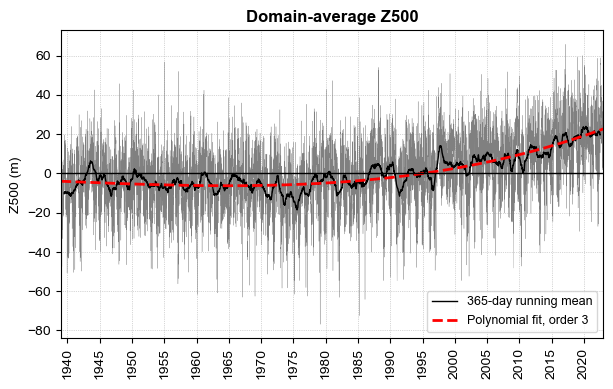

In [19]:
if year1<1979:
    fig, ax = plt.subplots(1,1,figsize=(7,4))
    ax.plot(t,avg_z500,lw=0.2,color='gray')
    ax.plot(t,np.array(pd.DataFrame(avg_z500).rolling(window=365,center=True).mean()),lw=1,color='k',label='365-day running mean')
    ax.plot(t,trendline,color='r',label="Polynomial fit, order "+str(degree),ls='--',lw=2)
    ax.axhline(0,color='k',lw=1)
    ax.set_xticks(np.arange(365,len(t),365*5))
    ax.set_xticklabels(years[:][::5],rotation=90)
    ax.grid(linestyle=':',lw=0.5)
    ax.set_ylabel("Z500 (m)")
    ax.legend(loc='lower right',fontsize=9)
    ax.set_xlim(0,len(trendline))
    ax.set_title("Domain-average Z500",weight="bold")
    #plt.savefig("atlantic_domain_avg_z500_"+str(year1)+"-"+str(year2)+".png",dpi=300,bbox_inches='tight',facecolor='w')

# Normalisation

In [20]:
## standard deviation normalization factor
## the area-mean standard deviation at each grid-point
gridpoint_std=np.std(z_anoms_detrend,axis=0)
z_std_area_avg_unfilter = np.average(np.mean(gridpoint_std,axis=-1),axis=-1,weights=np.cos(np.radians(lats)))
## smooth this
norm_factor = uniform_filter1d(z_std_area_avg_unfilter,size=std_smooth_days,axis=0,mode='wrap')

In [21]:
## map the trend
def trend_map():    
    plt.rcParams.update({'hatch.color': 'dimgray'})
   
    clevs = np.concatenate((np.arange(-12,0,1),np.arange(1,13,1)))
    cticks = np.arange(-12,14,2)

    ## specify extent of boundary
    extent =[np.min(lons),np.max(lons),np.min(lats),np.max(lats)]
    midlon = np.median(lons)
    midlat = np.median(lats)

    fig,axs = plt.subplots(2,2,figsize=(8,6),tight_layout=True,subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=midlon, central_latitude=midlat)})


    for a, ax in enumerate(axs.reshape(-1)):
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        boundary = make_boundary_path(*extent)
        ax.set_boundary(boundary, transform=ccrs.PlateCarree())
        
    cf1 = axs[0,0].contourf(lons,lats,365*10*z_trend,cmap='RdBu_r',extend='both',levels=clevs,transform=ccrs.PlateCarree())
    #axs[0,0].contourf(lons,lats,np.ma.masked_less(pvals_z,0.05),colors='none',hatches=['///'],transform=ccrs.PlateCarree())
    axs[0,0].set_title("(a) Full trend",weight="bold")
    
    cf2 = axs[1,0].contourf(lons,lats,365*10*z_eddy_trend,cmap='RdBu_r',extend='both',levels=clevs,transform=ccrs.PlateCarree())
    #axs[1,0].contourf(lons,lats,np.ma.masked_less(pvals_eddy,0.05),colors='none',hatches=['///'],transform=ccrs.PlateCarree())
    axs[1,0].set_title("(c) Residual trend",weight="bold")
    
    for a, ax in enumerate(axs.reshape(-1).take([0,2])):
        ax.coastlines(color='k',resolution='50m',linewidth=0.3)
        ax.add_feature(cfeature.STATES, zorder=1, linewidth=0.1, edgecolor='k')
        cb=fig.colorbar(cf1,ax=ax,orientation='horizontal',pad=0.03,spacing='proportional',ticks=cticks,aspect=30,shrink=0.9)
        cb.set_label("m per decade",fontsize=10)
        cb.ax.tick_params(labelsize=9)
 

    axs[0,1].remove()
    axs[1,1].remove()
    ax2 = fig.add_subplot(2, 2, 2)    
    ax2.plot(t,avg_z500,lw=0.2,color='gray')
    ax2.plot(t,np.array(pd.DataFrame(avg_z500).rolling(window=365,center=True).mean()),lw=1,color='k',label='365-day running mean')
    ax2.plot(t,trendline,color='r',label='Trend: '+str(np.round(365*10*avg_z500_trend[0],1))+" m per decade",ls='--',lw=2)
    ax2.axhline(0,color='k',lw=1)
    ax2.set_xticks(np.arange(365,len(t),365*5))
    ax2.set_xticklabels(years[1:][::5])
    ax2.grid(linestyle=':')
    ax2.set_ylabel("Z500 (m)")
    ax2.legend(loc='lower right',fontsize=9)
    ax2.set_xlim(0,len(trendline))
    ax2.set_yticks(np.arange(-100,100,25))
    ax2.set_title("(b) Domain-average Z500 & trend",weight="bold")

    ax3 = fig.add_subplot(2, 2, 4)  
    x = np.arange(0,365,1)
    ax3.plot(x,z_std_area_avg_unfilter,color='dimgray',lw=1)
    ax3.plot(x,norm_factor,label=str(std_smooth_days)+'-day running mean',color='purple')
    ax3.set_xlim(x.min(),x.max())
    ax3.set_xticks(np.arange(0,366,30))
    ax3.set_ylabel("Standard deviation (m)")
    ax3.legend(loc='upper center',fontsize=9)
    ax3.set_xticks(np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30]))
    ax3.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax3.grid(linestyle=':')
    ax3.set_title("(d) Domain-average Z500 standard deviation",weight="bold")
    ax3.set_yticks(np.arange(40,120,10))
    return fig
   

In [22]:
if year1>=1979:
    trend_map()

In [23]:
## normalize the data by this variance factor
z_norm = z_anoms_detrend/norm_factor[np.newaxis,:,np.newaxis,np.newaxis]

In [24]:
## flatten years, days
z_norm = z_norm.reshape(len(years)*365,len(lats),len(lons))
z_anoms_detrend = z_anoms_detrend.reshape(np.shape(z_norm))

In [25]:
time=time.flatten()

# EOF analysis

In [27]:
##Square-root cosine weights for EOF analysis
weights = np.sqrt(np.cos(np.radians(lats)))
## EOF analysis

In [28]:
print("Performing EOF analysis...")
solver = Eof(z_norm,weights=weights[:,np.newaxis])
print("EOF analysis completed!")

Performing EOF analysis...


/var/folders/5s/d7y8lxv96bn4c5srcfjyn09h0000gq/T/ipykernel_38314/11574788.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  solver = Eof(z_norm,weights=weights[:,np.newaxis])


EOF analysis completed!


In [29]:
# retain 80% of variance
cum_var_frac = np.cumsum(solver.varianceFraction())
n_eof = 1+np.where(cum_var_frac>0.8)[0][0]
print(n_eof)

12


In [30]:
## return the quantities from the eof analysis
## pcs, no scaling
pcs = solver.pcs(npcs=n_eof,pcscaling=0) ## do not standardize
eigs = solver.eigenvalues(neigs=n_eof)
var_frac = solver.varianceFraction(neigs=n_eof)
eofs = solver.eofs(neofs=n_eof,eofscaling=0)

In [31]:
print(np.round(100*np.sum(var_frac),1))

81.1


In [32]:
def eof_map():
    fig, axs = plt.subplots(1,3,layout="constrained",figsize=(8,3),subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=np.median(lons), central_latitude=np.median(lats))})
    extent =[np.min(lons),np.max(lons),np.min(lats),np.max(lats)]
    clevs = np.concatenate((np.arange(-1.2,0,0.1),np.arange(0.1,1.3,0.1)))

    for a, ax in enumerate(axs.flatten()):
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        boundary = make_boundary_path(*extent)
        ax.set_boundary(boundary, transform=ccrs.PlateCarree())
        cf = ax.contourf(lons,lats,(eofs[a]*np.sqrt(eigs[a]))/weights[:,np.newaxis],cmap='RdBu_r',extend='both',levels=clevs,transform=ccrs.PlateCarree())
        ax.coastlines(color='k',resolution='50m',linewidth=0.2)
        ax.add_feature(cfeature.STATES, zorder=1, linewidth=0.1, edgecolor='k')
        ax.set_title(" EOF"+str(a+1)+" ("+str(np.round(var_frac[a]*100,1))+"%)",weight="bold",fontsize=11)

    cticks = np.arange(-2,2.2,0.2)
    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.05])
    cb = fig.colorbar(cf, cax=cb_ax,orientation="horizontal",ticks=cticks,extend="both",spacing='proportional')
    cb.set_label("Normalized Z500 anomaly per $\sigma$ of PC",fontsize=10)
    cb.ax.tick_params(labelsize=10)

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/var/folders/5s/d7y8lxv96bn4c5srcfjyn09h0000gq/T/ipykernel_38314/2242574197.py:18: SyntaxWarning: invalid escape sequence '\s'
  cb.set_label("Normalized Z500 anomaly per $\sigma$ of PC",fontsize=10)


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


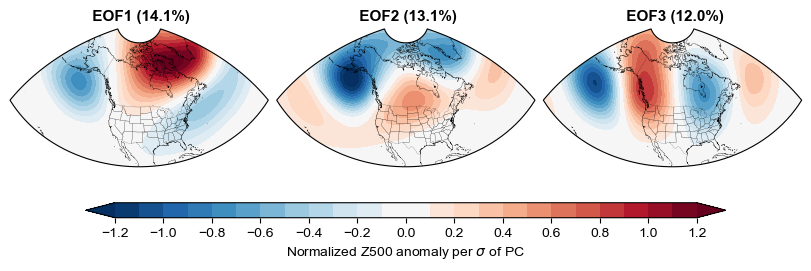

In [33]:
eof_map()

# Clustering

In [34]:
ncluster=4

In [35]:
# Clustering!
print ("Begin K-means clustering with",ncluster,"clusters")
## The random state parameter allows for reproducibility
kmeans = KMeans(n_clusters=ncluster, n_init=500, max_iter=500,random_state=42).fit(pcs)
print(kmeans.n_iter_,"iterations")
print("Clustering completed!")

Begin K-means clustering with 4 clusters
31 iterations
Clustering completed!


In [36]:
distances = kmeans.transform(pcs)
raw_regime = kmeans.labels_ ## regime of each day
centroids_raw = kmeans.cluster_centers_

In [37]:
## cluster distances
dist_to_centroid = np.min(distances,axis=1)

In [38]:
centroids = np.full((ncluster+1,pcs.shape[1]),np.nan)
centroids[:ncluster]=centroids_raw
# generate new "no regime" centroid of zeroes
centroids[-1]=np.zeros(pcs.shape[1])

In [39]:
## distance to the 'no regime' centroid
dist_to_climo=np.full(len(time),np.nan)
for d in range(len(time)):
    dist_to_climo[d]=euclid_dist(pcs[d],centroids[-1])

In [40]:
noreg_id = ncluster

In [41]:
## reassign regimes if they are closest to climatology
daily_regime = np.copy(raw_regime)
daily_regime[dist_to_climo<dist_to_centroid]=noreg_id
print("Frequency of no regime: ",np.round(100*np.sum(daily_regime==noreg_id)/len(daily_regime),1),"%")

Frequency of no regime:  13.8 %


In [42]:
## reassign dist to centroid as dist to climo if no regime is specified
for i in range(len(daily_regime)):
    if daily_regime[i]==noreg_id:
        dist_to_centroid[i]=dist_to_climo[i]

In [43]:
# Specify the regime ID by its occupation frequency
# Calculate what percentage of days fall into each type
ratios = np.full(ncluster+1,np.nan)
for i in range(ncluster+1):
	ratios[i] = 100*(np.sum(daily_regime==i)/len(daily_regime))

ratios_sorted = np.sort(ratios)[::-1]
# make new array to input the new identifiers
new_clust = np.full(np.shape(daily_regime),np.nan)
new_centroids = np.full(np.shape(centroids),np.nan)
sort_labs = np.full(ncluster+1,np.nan,dtype=int) ## this stores what the unsorted labels are

for i in range(ncluster+1):
    new_id = int(np.where(ratios_sorted==ratios[i])[0][0])
    sort_labs[i]=new_id
    new_clust[np.where(daily_regime==i)[0]]=new_id
    new_centroids[new_id]=centroids[i]

daily_regime=new_clust
centroids=new_centroids

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [50]:
regnames = ['Pacific Trough (PT)','Pacific Ridge (PR)','Greenland High (GH)','Alaskan Ridge (AKR)','No Regime']
regnames_short = ['PT','PR','AKR','GH','NO']
regcols=['purple','cornflowerblue','orange','tomato','gray']

In [51]:
## compute cluster mean anomalies
regime_composite_std = np.full((ncluster+1,len(lats),len(lons)),np.nan)
regime_composite_raw= np.full(np.shape(regime_composite_std),np.nan)

for r in range(ncluster+1):
    subset = np.where(daily_regime==r)[0]
    regime_composite_std[r] = np.mean(z_norm[subset],axis=0)
    regime_composite_raw[r] = np.mean(z_anoms_detrend[subset],axis=0)

In [58]:
def regime_composite_fig():
    clevs = np.concatenate((np.arange(-1.8,-0.1,0.1),np.arange(0.2,1.9,0.1)))
    cticks = np.arange(-1.8,1.9,0.4)
    
    ## specify extent of boundary
    extent =[np.min(lons),np.max(lons),np.min(lats),np.max(lats)]
    midlon = (extent[0]+extent[1])/2
    midlat = (extent[2]+extent[3])/2

    fig,axs = plt.subplots(2,2,figsize=(7,4),layout="constrained",subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=np.median(lons), central_latitude=np.median(lats))})

    for a, ax in enumerate(axs.reshape(-1)):
        #if a<ncluster:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        boundary = make_boundary_path(*extent)
        ax.set_boundary(boundary, transform=ccrs.PlateCarree())
        cf = ax.contourf(lons,lats,regime_composite_std[a],cmap='RdBu_r',extend='both',levels=clevs,transform=ccrs.PlateCarree())
        ax.coastlines(color='k',resolution='50m',linewidth=0.2)
        ax.add_feature(cfeature.STATES, zorder=1, linewidth=0.1, edgecolor='k')
        ax.set_title(str(regnames[a])+" "+str(np.round(ratios_sorted[a],1))+"%",weight="bold")
        
    cb_ax = fig.add_axes([0.075, -0.05, 0.85, 0.03])
    cbar = fig.colorbar(cf, cax=cb_ax,orientation="horizontal",ticks=cticks,extend="both",spacing='proportional')
    cbar.set_label(r"Normalised 500 hPa geopotential height anomaly ($\sigma$)",fontsize=10)



/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


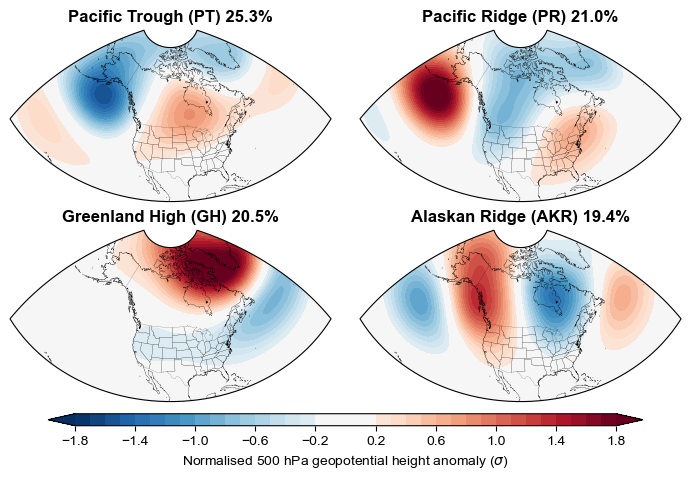

In [59]:
regime_composite_fig()

In [56]:
time_strs = [str(t.year)+"-"+str(t.month).zfill(2)+"-"+str(t.day).zfill(2) for t in time]
cluster_df = pd.DataFrame(daily_regime, index=time_strs,dtype='int',columns=['Regime: 0 = Pac Trough, 1 = Pac Ridge,  2 = Greenland High,3= Alaskan Ridge, 4 = No regime'])
# Save series output

# cluster_df.to_csv('year_round_namerica_regimes_'+str(ncluster+1)+'_classes_'+str(year1)+'_'+str(year2)+'_running_mean.csv', sep=',', index=True,header=True)

# WRI

In [49]:
## Compute the WR time series similar to Michel and Riviere 2011 JAS
## cos lat weights
weights_iwr = np.cos(np.radians(lats))[:,np.newaxis]

## Project each day onto composite regime map
projection = np.zeros((ncluster+1,len(time)))
for r in range(ncluster+1):
    for d in range(len(time)):
        projection[r,d]=np.dot((z_norm[d]).flatten(),(regime_composite_std[r]*weights_iwr).flatten())

## Calculate mean projection across all days
mean_proj = np.mean(projection,axis=1)
# ## Calculate std dev of projection across all days
std_dev_proj = np.std(projection,axis=1)

## Compute normalized weather regime projection WRI
WRI = (projection-mean_proj[:,np.newaxis])/std_dev_proj[:,np.newaxis]